# Week 11 Exercise 2 Notebook
In this notebook, we'll collect the code snippets to get you started on Bayesian inference for Data Fusion. 
*Note that there are sections of the code omitted, and you will need to fill these in yourself*.

## Step 0: Load your data.
The data for this exercise are linked in moodle and the handout, `wk11_pendulum_sensor_data.csv`. They contain simulated readings from an accelerometer and magentic sensor coupled to a pendulum actuator in a manufacturing context. 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_path = "wk11_pendulum_sensor_data.csv"
df = pd.read_csv(df_path)

t = df['time'].values
acc = df['acc'].values
mag = df['mag'].values
# TO DO  - extract acc and mag data from the dataframe as well. 

## Step 1: Define Your Hypotheses
In this case, we define a range of possible periods for the pendulum swing, from 0.1 to 1.25 seconds.

In [5]:
hypotheses = np.arange(0.1, 1.25, 0.01)
n_hyp = len(hypotheses)

## Step 2: Define the Prior Distribution
The prior is your expectation for the period. In this case, it's pretty reasonable to go in with a flat prior - every hypothesis is equally likely. But in many situations, you have expectations you can use to shape the results. 

**Try it**: Try this exercise again, defining a function (maybe a Gaussian) that sets the expectation that the true period is near the middle of the range of possible hypotheses. This is pretty reasonable as well, given that we've probably set a generous range of hypotheses that extends outside what we expect to find.

In [6]:
# Prior: uniform
prior = np.ones(n_hyp) / n_hyp

## Step 3: Define the likelihoods 
There are two steps to defining the likelihood - A, decide on the shape of the function, often Gaussian; B, determine its parameters. This may be based on data, your experience, or just a guess.

In this instance, we'll use the data to estimate the mean of the Gaussian, and use our expectations of the sensors (acceleration is noisier than magnetic) to determin their standard deviations.

In [7]:
def likelihood(det_period, hypothesis_periods, sigma):
    return np.exp(-0.5 * ((det_period - hypothesis_periods) / sigma) ** 2)

acc_sigma = 0.05
mag_sigma = 0.03 

## Step 4: Extract the features from the data -- in this case, the period of the pendulum

We use a threshold to detect the peaks in the magnetic sensor data, and zero crossings in the accelerometer. 


In [10]:
def estimate_periods(signal, method='zero_crossing'):
    times = []
    if method == 'zero_crossing':
        crossings = np.where(np.diff(np.signbit(signal)))[0]
        times = t[crossings]
    elif method == 'peaks':
        peaks = np.where(signal > 0.6)[0]
        times = t[peaks]
    if len(times) > 1:
        periods = np.diff(times)
        return np.mean(periods)
    return None

# Estimate periods
acc_period = estimate_periods(acc, method='zero_crossing')
mag_period = estimate_periods(mag, method='peaks')

# convert estimates to likelihoods (assume Gaussian)
L_acc = likelihood(acc_period, hypotheses, sigma=acc_sigma)
L_mag = likelihood(mag_period, hypotheses, sigma=mag_sigma)


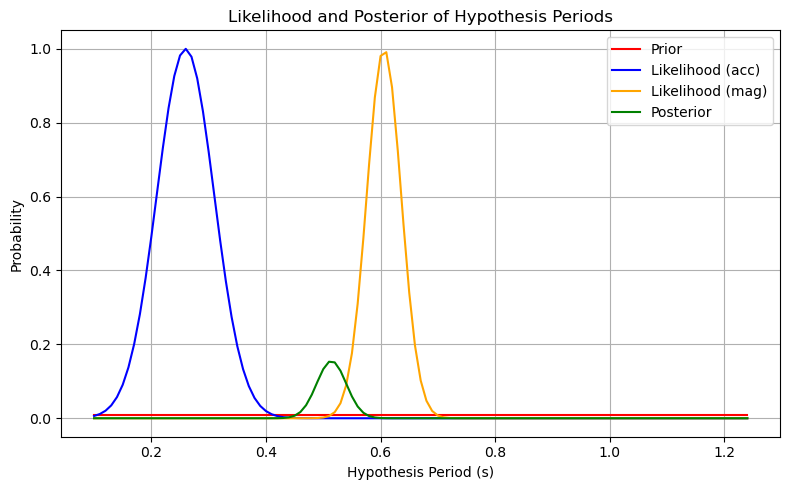

Estimated period from acceleration: 0.26 s
Estimated period from magnetometer: 0.61 s
MAP estimate: 0.51 s


In [12]:
## Combine the evidence

unnormalized_posterior = L_acc * L_mag * prior
posterior = unnormalized_posterior / np.sum(unnormalized_posterior)

# MAP estimate
map_estimates = hypotheses[np.nanargmax(posterior, axis=0)]

# plot the likelihoods
plt.figure(figsize=(8, 5))
plt.plot(hypotheses, prior, label='Prior', color='red')
plt.plot(hypotheses, L_acc, label='Likelihood (acc)', color='blue')
plt.plot(hypotheses, L_mag, label='Likelihood (mag)', color='orange')
plt.plot(hypotheses, posterior, label='Posterior', color='green')
plt.xlabel('Hypothesis Period (s)')
plt.ylabel('Probability')
plt.title('Likelihood and Posterior of Hypothesis Periods')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"Estimated period from acceleration: {acc_period:.2f} s")
print(f"Estimated period from magnetometer: {mag_period:.2f} s")
print(f"MAP estimate: {map_estimates:.2f} s")